# Loading data and converting to dataframe

# Load data from .xlsx file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import datetime


## Solar intensity data

In [2]:
#Load initial data
hourly_sun_intensity = pd.read_excel('2-10_21_524-2 Andmed.xlsx', sheet_name = 'tunni sum.kiirgus', header = 1)

In [3]:
hourly_sun_intensity.head()

,Aasta,Kuu,Päaev,Kell (UTC),"Haapsalu summaarne kiirgus, W/m²","Tallinn-Harku summaarne kiirgus, W/m²","Narva summaarne kiirgus, W/m²","Narva-Jõesuu summaarne kiirgus, W/m²","Pärnu summaarne kiirgus, W/m²","Pärnu-Sauga summaarne kiirgus, W/m²","Roomassaare summaarne kiirgus, W/m²","Tartu-Tõravere summaarne kiirgus, W/m²","Tiirikoja summaarne kiirgus, W/m²","Vilsandi summaarne kiirgus, W/m²"
0,2010,1,1,00:00:00,NaN,0,NaN,0.0,NaN,0.0,0.0,0,0.0,0.0
1,2010,1,1,01:00:00,NaN,0,NaN,1.0,NaN,1.0,0.0,0,0.0,0.0
2,2010,1,1,02:00:00,NaN,0,NaN,0.0,NaN,1.0,0.0,0,0.0,0.0
3,2010,1,1,03:00:00,NaN,0,NaN,0.0,NaN,1.0,0.0,0,0.0,0.0
4,2010,1,1,04:00:00,NaN,0,NaN,0.0,NaN,0.0,0.0,0,0.0,0.0


In [4]:
#Update column names by shortening them and converting to English
newColumnNames = dict()
newColumnNames["Aasta"] = "y"
newColumnNames["Kuu"] = "m"
newColumnNames["Päaev"] = "d"
newColumnNames["Kell (UTC)"] = "time"
for columnName in hourly_sun_intensity.columns:
    if "kiirgus" in columnName:
        newColumnNames[columnName] = "solar_"+columnName.replace(" summaarne kiirgus, W/m²", "")
#newColumnNames = ["y", "m", "d", "time"]+["solar_"+columnName.replace(" summaarne kiirgus, W/m²", "") for columnName in hourly_sun_intensity.columns if "kiirgus" in columnName]
hourly_sun_intensity = hourly_sun_intensity.rename(columns=newColumnNames)
#hourly_sun_intensity.columns = newColumnNames

In [5]:
hourly_sun_intensity.head()

,y,m,d,time,solar_Haapsalu,solar_Tallinn-Harku,solar_Narva,solar_Narva-Jõesuu,solar_Pärnu,solar_Pärnu-Sauga,solar_Roomassaare,solar_Tartu-Tõravere,solar_Tiirikoja,solar_Vilsandi
0,2010,1,1,00:00:00,NaN,0,NaN,0.0,NaN,0.0,0.0,0,0.0,0.0
1,2010,1,1,01:00:00,NaN,0,NaN,1.0,NaN,1.0,0.0,0,0.0,0.0
2,2010,1,1,02:00:00,NaN,0,NaN,0.0,NaN,1.0,0.0,0,0.0,0.0
3,2010,1,1,03:00:00,NaN,0,NaN,0.0,NaN,1.0,0.0,0,0.0,0.0
4,2010,1,1,04:00:00,NaN,0,NaN,0.0,NaN,0.0,0.0,0,0.0,0.0


In [6]:
# Some weather stations have changed locations over time, as the differences between their locations are rather small (less than 8 km)
# We at first do not make separation between them

def join_columns(c1, c2, nc, df, column_id): # Function for joining columns, where an area has two weather measuring points
    data = []
    cs = [c1, c2]
    for i, rows in df[cs].iterrows():
        if (pd.isna(rows[0]) == True) & (pd.isna(rows[1]) == False):
            data.append(round(rows[1], 2))
        elif (pd.isna(rows[0]) == False) & (pd.isna(rows[1]) == True):
            data.append(round(rows[0], 2))
        elif (pd.isna(rows[0]) == False) & (pd.isna(rows[1]) == False):
            data.append(round(rows.mean(), 2))
        elif (pd.isna(rows[0]) == True) & (pd.isna(rows[1]) == True):
            data.append(rows[0])

    df = df.drop(columns = [c1, c2])
    df.insert(column_id, nc, data)
    
    return df

In [7]:
#Merge columns, which are due to weather station moving
hourly_sun_intensity = join_columns('solar_Narva', 'solar_Narva-Jõesuu', 'solar_Narva', hourly_sun_intensity, 4)
hourly_sun_intensity = join_columns('solar_Pärnu-Sauga', 'solar_Pärnu', 'solar_Pärnu', hourly_sun_intensity, 5)

In [8]:
#Drop rows where some value is missing
hourly_sun_intensity = hourly_sun_intensity.dropna()
#If value is -1 it corresponds to night, set it to 0
hourly_sun_intensity = hourly_sun_intensity.replace(-1, 0)

In [9]:
#Shift the times -X minutes to facilitate predicting future solar intensity from existing
def shiftDateTime(df, numberOfHours):
    dateTimes = []
    for i in range(len(df)):
        row = df.iloc[i]
        dateTimes+=[datetime.datetime.combine(datetime.date(row.y, row.m, row.d), row.time)+datetime.timedelta(hours=numberOfHours)]
    df2 = copy.deepcopy(df)
    df2["y"] = [date.year for date in dateTimes]
    df2["m"] = [date.month for date in dateTimes]
    df2["d"] = [date.day for date in dateTimes]
    df2["time"] = [date.time() for date in dateTimes]
    
    return df2
    
    

In [10]:
hourly_sun_intensity_Shifted = shiftDateTime(hourly_sun_intensity, -1)

## Data from different weather stations

#### Locations


Tallinn-Harku
Laius: N 59°23´53´´
Pikkus: E 24°36´10´´
Decimal
Lat: 59.398055
Long: 24.602778


Haapsalu meteoroloogiajaam
Laius N 58°56´40´´
Pikkus E 23°33´18´´
Decimal
Lat: 58.944444
Long: 23.555

Narva
Laius: N 59°23´22´´
Pikkus: E 28°06´33´´
Decimal
Lat: 59.389444
Long: 28.109167

Pärnu
Laius: N 58°23´4,44´´
Pikkus: E 24°29´6,71´´
Decimal
Lat: 58.384556
Long: 24.485197

Roomassaare
Laius: N 58°13’05”
Pikkus: E 22°30’23”
Decimal
Lat: 58.218056 
Long: 22.506389 

Tartu-Tõravere meteoroloogiajaam
Laius: N 58°15´51´´
Pikkus: E 26°27´41´
Decimal
Lat: 58.264167
Long: 26.461389

Tiirikoja järvejaam
Laius: N 58°51´55´´
Pikkus: E 26°57´08´´
Decimal
Lat: 58.865278
Long: 26.952222

Vilsandi rannikujaam
Laius: N 58°22´58”
Pikkus: E 21°48´51”
Deciaml
Lat: 58.382778
Long: 21.814167

In [11]:
weather_station_coordinates = dict()
weather_station_coordinates["tallinn"] = [59.398055, 24.602778]
weather_station_coordinates["haapsalu"] = [58.944444, 23.555]
weather_station_coordinates["narva"] = [59.389444, 28.109167]
weather_station_coordinates["parnu"] = [59.389444, 28.109167]
weather_station_coordinates["roomassaare"] = [58.218056, 22.506389]
weather_station_coordinates["tartu"] = [58.264167, 26.461389]
weather_station_coordinates["tiirikoja"] = [58.865278, 26.952222]
weather_station_coordinates["vilsandi"] = [58.382778, 21.814167]

In [29]:
selectedColumns = ["Aasta", "Kuu", "Päev", "Kell (UTC)", "Õhutemperatuur °C", "10 minuti keskmine tuule kiirus m/s", "Õhurõhk jaama kõrgusel hPa", "Suhteline õhuniiskus %", "10 minuti keskmine tuule suund"]

In [30]:
#Update column names by shortening them and converting to English

def updateColumnNames(df, location):
    newColumnNames = dict()
    newColumnNames["Aasta"] = "y"
    newColumnNames["Kuu"] = "m"
    newColumnNames["Päev"] = "d"
    newColumnNames["Kell (UTC)"] = "time"
    newColumnNames["Õhutemperatuur °C"] = f"temp_{location}"
    newColumnNames["10 minuti keskmine tuule kiirus m/s"] = f"wind_speed_{location}"
    newColumnNames["Õhurõhk jaama kõrgusel hPa"] = f"pressure_{location}"
    newColumnNames["Suhteline õhuniiskus %"] = f"rel_humidity_{location}"
    newColumnNames["10 minuti keskmine tuule suund"] = f"wind_dir_{location}"
    df = df.rename(columns=newColumnNames)
    return df

In [31]:
def getFromXlsx(filename, columns, location):
    #Load xlsx
    df = pd.read_excel(filename, header = 1)
    df = df[columns]
    #Drop rows where data is missing
    #df = df.dropna()
    #Update column names for clarity
    df = updateColumnNames(df, location)
    return df

In [32]:
#Get Tallinn
data_tallinn = getFromXlsx("./data/Tallinn-Harku_2004-2020.xlsx", selectedColumns, "tallinn")
#data_tallinn["lat_tallinn"] = len(data_tallinn)*[weather_station_coordinates["tallinn"][0]]
#data_tallinn["long_tallinn"] = len(data_tallinn)*[weather_station_coordinates["tallinn"][1]]
#Get Roomassaare
#data_roomassaare = getFromXlsx("./data/Roomassaare_2008-2020.xlsx", selectedColumns, "roomassaare")
#data_roomassaare["lat_roomassaare"] = len(data_roomassaare)*[weather_station_coordinates["roomassaare"][0]]
#data_roomassaare["long_roomassaare"] = len(data_roomassaare)*[weather_station_coordinates["roomassaare"][1]]
#Merge tables
#data_weather = data_tallinn.merge(data_roomassaare, how='left', on=["y", "m", "d", "time"])

## Check, which variables correlate

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


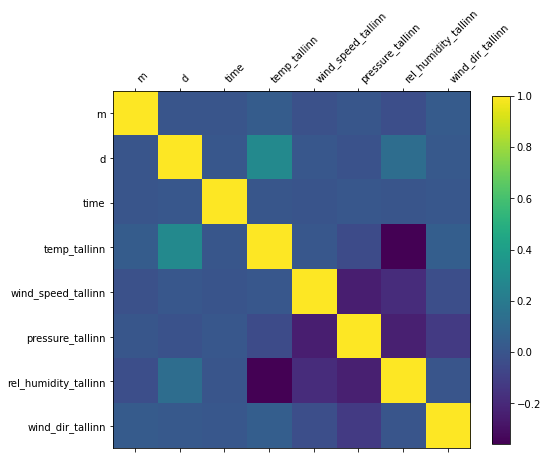

In [33]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(data_tallinn.corr())
ax.set_xticklabels(data_tallinn.columns, rotation = 45, ha="left")
ax.set_yticklabels(data_tallinn.columns)
#ax.set_xticks(np.arange(0,8,1))
#ax.set_yticks(np.arange(0,8,1))
#ax.set_ylim(bottom=8.5, top=-0.5)
fig.colorbar(cax, shrink=0.8)

plt.show()

# Check, which variables correlate with Solar intensity

In [34]:
data_solar_weather = data_tallinn.merge(hourly_sun_intensity, how='left', on=["y", "m", "d", "time"])

In [35]:
data_solar_weather.columns

Index(['y', 'm', 'd', 'time', 'temp_tallinn', 'wind_speed_tallinn',
       'pressure_tallinn', 'rel_humidity_tallinn', 'wind_dir_tallinn',
       'solar_Narva', 'solar_Pärnu', 'solar_Haapsalu', 'solar_Tallinn-Harku',
       'solar_Roomassaare', 'solar_Tartu-Tõravere', 'solar_Tiirikoja',
       'solar_Vilsandi'],
      dtype='object')

In [36]:
data_solar_weather_tallinn = data_solar_weather[['y', 'm', 'd', 'time', 'temp_tallinn', 'wind_speed_tallinn',
       'pressure_tallinn', 'rel_humidity_tallinn', 'solar_Tallinn-Harku']]

<AxesSubplot:>

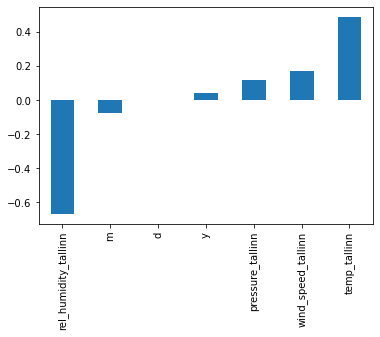

In [37]:

data_solar_weather_tallinn.corr().loc['solar_Tallinn-Harku'].drop(['solar_Tallinn-Harku']).sort_values().plot.bar()

## Same test, but solar intensity data is shifted

In [38]:
data_solar_weather = data_tallinn.merge(hourly_sun_intensity_Shifted, how='left', on=["y", "m", "d", "time"])

In [41]:
data_solar_weather_tallinn = data_solar_weather[['y', 'm', 'd', 'time', 'temp_tallinn', 'wind_speed_tallinn', "wind_dir_tallinn",
       'pressure_tallinn', 'rel_humidity_tallinn', 'solar_Tallinn-Harku']]

<AxesSubplot:>

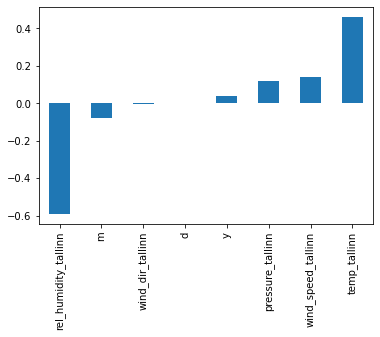

In [42]:

data_solar_weather_tallinn.corr().loc['solar_Tallinn-Harku'].drop(['solar_Tallinn-Harku']).sort_values().plot.bar()

In [26]:
#Get Vilsandi
data_vilsandi = getFromXlsx("./data/Vilsandi_2004-2020.xlsx", selectedColumns, "vilsandi")
#data_vilsandi["lat_vilsandi"] = len(data_vilsandi)*[weather_station_coordinates["vilsandi"][0]]
#data_vilsandi["long_vilsandi"] = len(data_vilsandi)*[weather_station_coordinates["vilsandi"][1]]
#Merge tables
data_weather = data_weather.merge(data_vilsandi, how='left', on=["y", "m", "d", "time"])

In [27]:
##Get Parnu
#data_parnu1 = getFromXlsx("./data/Parnu-Sauga_01.12.2004-31.03.2019.xlsx", selectedColumns, "parnu")
#data_parnu2 = getFromXlsx("./data/Parnu_01.04.2019-2020.xlsx", selectedColumns, "parnu")
#data_parnu = data_parnu1.append(data_parnu2)

##Merge tables
#data_weather = data_weather.merge(data_parnu, how='left', on=["y", "m", "d", "time"])

In [28]:
data_Tartu = getFromXlsx("./data/Tartu-Toravere_2004-2020.xlsx", selectedColumns, "tartu")
#data_Tartu["lat_tartu"] = len(data_Tartu)*[weather_station_coordinates["tartu"][0]]
#data_Tartu["long_tartu"] = len(data_Tartu)*[weather_station_coordinates["tartu"][1]]
#Merge tables

data_weather = data_weather.merge(data_Tartu, how='left', on=["y", "m", "d", "time"])


In [29]:
#Once again drop all rows where some row is missing
data_weather = data_weather.dropna()

In [30]:
data_weather

,y,m,d,time,temp_tallinn,wind_speed_tallinn,temp_roomassaare,wind_speed_roomassaare,temp_vilsandi,wind_speed_vilsandi,temp_tartu,wind_speed_tartu
35064,2008,1,1,00:00:00,-0.5,3.0,1.3,7.0,0.6,4.0,-1.9,2.2
35065,2008,1,1,01:00:00,-0.7,3.3,1.2,7.1,0.4,2.7,-1.9,2.3
35066,2008,1,1,02:00:00,-0.9,3.2,1.3,7.2,0.2,2.9,-2.0,2.7
35067,2008,1,1,03:00:00,-0.9,3.4,0.8,8.3,0.1,3.5,-2.2,2.8
35068,2008,1,1,04:00:00,-0.9,4.3,0.8,8.4,-0.3,3.8,-2.2,2.6
...,...,...,...,...,...,...,...,...,...,...,...,...
149035,2020,12,31,19:00:00,0.5,1.5,2.8,2.0,3.7,4.8,1.1,1.1
149036,2020,12,31,20:00:00,0.2,2.6,2.6,5.5,3.4,6.3,1.0,1.5
149037,2020,12,31,21:00:00,0.2,2.3,2.7,3.3,3.4,5.0,0.8,1.4
149038,2020,12,31,22:00:00,0.1,1.8,2.9,4.1,2.9,3.1,0.5,1.0


## Join weather and solar data

In [31]:
data_solar_weather = hourly_sun_intensity_Shifted.merge(data_weather, how='left', on=["y", "m", "d", "time"])

In [33]:
data_solar_weather.dropna()

,y,m,d,time,solar_Narva,solar_Pärnu,solar_Haapsalu,solar_Tallinn-Harku,solar_Roomassaare,solar_Tartu-Tõravere,solar_Tiirikoja,solar_Vilsandi,temp_tallinn,wind_speed_tallinn,temp_roomassaare,wind_speed_roomassaare,temp_vilsandi,wind_speed_vilsandi,temp_tartu,wind_speed_tartu
0,2010,4,14,11:00:00,634.0,384.0,652.0,603,673.0,371,380.0,676.0,10.2,3.4,11.8,4.7,4.5,6.8,12.2,2.1
1,2010,4,14,12:00:00,552.0,297.0,577.0,540,611.0,328,361.0,610.0,9.7,2.9,12.0,4.7,4.7,7.0,13.6,2.7
2,2010,4,14,13:00:00,450.0,381.0,484.0,441,511.0,317,361.0,521.0,10.2,2.3,12.2,4.4,4.6,7.1,12.8,2.7
3,2010,4,14,14:00:00,326.0,375.0,384.0,319,380.0,265,335.0,397.0,9.7,2.1,11.6,6.4,4.3,6.5,11.9,2.7
4,2010,4,14,15:00:00,117.0,239.0,250.0,189,237.0,101,199.0,256.0,10.4,1.7,10.6,5.3,4.0,6.8,11.3,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88783,2020,12,31,18:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.5,1.5,2.7,2.0,3.5,3.8,1.1,1.5
88784,2020,12,31,19:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.5,1.5,2.8,2.0,3.7,4.8,1.1,1.1
88785,2020,12,31,20:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.2,2.6,2.6,5.5,3.4,6.3,1.0,1.5
88786,2020,12,31,21:00:00,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.2,2.3,2.7,3.3,3.4,5.0,0.8,1.4
